# Investigation of Time Step Sampling in Frequency Domain

## Introduction

This report summarizes my investigation so far into optimizing time step sampling for the training of Denoising Diffusion Probabilistic Models (DDPMs), inspired by Robin Rombach’s guest lecture at TUM ([YouTube link](https://www.youtube.com/live/nrKKLJXBSw0)). Rombach noted that sampling time steps $t$ from a logit-normal distribution improves efficiency over uniform sampling. Building on this, I explore approaches to further enhance performance by adjusting the sampling distribution to prioritize time steps where the most significant information synthesis occurs, leveraging a frequency domain perspective.

The preceeding assumption is that image information is unevenly distributed across frequencies, with certain bands containing more critical content. By interpreting DDPMs as performing autocorrelation in the frequency domain, I hypothesize that allocating more training effort to time steps $t$ where key information is synthesized can yield superior models. To achieve this, I investigate the idea of weighting the sampling distribution using the image’s power spectrum to emphasize frequencies with high information content. While this per-image preprocessing is computationally intensive, it can be performed once to enrich the dataset, potentially improving training outcomes. 

This report contains inital results, aswell as other insights from frequency domain analysis, including adjustment for resolution scaling similar to existing methods.

## Outline

1. **Image Collection**  
Sourcing high- and low-resolution images from Unsplash.

2. **Latent Space Encoding**  
Encoding images into latent space using the Flux Variational Autoencoder.

3. **Noise Interpolation**  
Blending latent tensors with Gaussian noise at varying $t$ values.

4. **FFT Preprocessing**  
Applying Fast Fourier Transform with a Kaiser window to minimize spectral leakage.

5. **Frequency Domain Analysis**  
Computing the Radial Averaged Power Spectrum (RAPS) to study noise and resolution effects.

6. **Weighting the Sampling Distribution**  
Find strategies to weight the sampling distribution of $t$ with the RAPS.

6. **Adjusting the Sampling Distribution for Resolution Compensation**  
Deriving a resolution-adaptive sampling distribution for $t$ and validating with visualizations.

7. **Comparison with Literature**  
Comparing findings with Esser et al. 2024 and hypothesizing discrepancies.

## Image Collection

To investigate time step sampling in the frequency domain, a dataset of images is sourced from Unsplash. The list of image URLs, stored in the variable `image_urls`, can be customized to select specific images for analysis. Each image undergoes preprocessing to ensure consistency and compatibility with the subsequent frequency domain analysis and DDPM training. Specifically, images are cropped to a square aspect ratio and resized to two resolutions, defined by the variables `high_res` and `low_res`. Both resolutions are processed for each image to enable comparative analysis across different scales.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


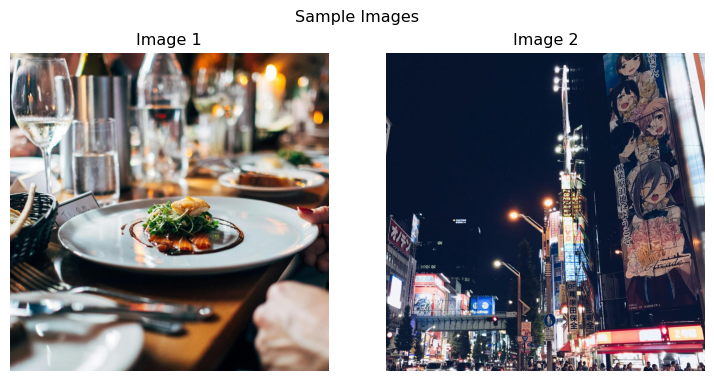

In [86]:
# These magic commands autoreload imports on execution for easy debugging of imported custom modules
%load_ext autoreload
%autoreload 2

from util import *


# Sample high-resolution images from Unsplash that are free to use
image_urls = [
    "https://images.unsplash.com/photo-1414235077428-338989a2e8c0",   # Dinner
    # "https://images.unsplash.com/photo-1506744038136-46273834b3fb",  # Yosemite
    # "https://images.unsplash.com/photo-1532274402911-5a369e4c4bb5",  # Landscape
    "https://images.unsplash.com/photo-1559981421-3e0c0d712e3b",  # Tokyo
    # "https://images.unsplash.com/photo-1544005313-94ddf0286df2",   # Portrait
    # "https://images.unsplash.com/photo-1716045168176-15d310a01dc0",   # Cartoon
]

# The 2 resolutions used for comparison in the following sections
high_res = 1024
low_res = 512

# Download images from URL, rescale to specified resolution and save to /images
x_high = load_images(image_urls, high_res)
x_low = load_images(image_urls, low_res)

# Visualize the images
b, c, h, w = x_high.shape  # b is batch size, c are channels, h and w are image dimensions
fig, axes = plt.subplots(1, b, figsize=(b * 4, 4), dpi=96)
if b < 2:
    axes = [axes]
for b_idx in range(b):
    ax = axes[b_idx]
    # Convert to hwc format for RGB images
    image = x_high[b_idx].permute(1, 2, 0)
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f"Image {b_idx + 1}")
plt.suptitle("Sample Images")
plt.tight_layout()
plt.show()

## Latent Space Encoding

High and low resolution versions of the selected images are encoded into latent space using the Flux Variational Autoencoder (VAE), with shifting and scaling applied as in the diffusion pipeline. To access the FLUX.1-dev VAE, login to Hugging Face with appropriate credentials and permissions to download the model is required.

In [87]:
# Login to Huggingface
huggingface_hub.login(new_session=False)

# Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Download FLux VAE from huggingface and load into memory
vae = load_flux_vae(device)

# Transfer image tensors to torch device (GPU/CPU)
x_high = x_high.to(device)
x_low = x_low.to(device)

# Encode image tensors into latent space
with torch.no_grad():
    z_high = vae.encode(x_high).latent_dist.mode()
    z_low = vae.encode(x_low).latent_dist.mode()

# Apply shift and scale like in diffusion pipeline
z_high = (z_high - vae.config.shift_factor) * vae.config.scaling_factor
z_low = (z_low - vae.config.shift_factor) * vae.config.scaling_factor

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

## Noise Interpolation

Gaussian noise $\epsilon \sim \mathcal{N}(0, 1)$ is blended with the latent representations of images using an interpolation factor $t$. This process simulates the forward diffusion process, where $t$ controls the noise level, ranging from 1 (original latent) to 0 (pure noise). The accompanying plot reveals that latent representations of high-resolution images retain more structural information at equivalent $t$ values compared to low-resolution counterparts. This observation will be confirmed in the following analysis. The plot compares latent channels of high- and low-resolution images at a fixed $t$. The high-resolution latent channels exhibit less noise corruption, indicating greater preservation of meaningful features.


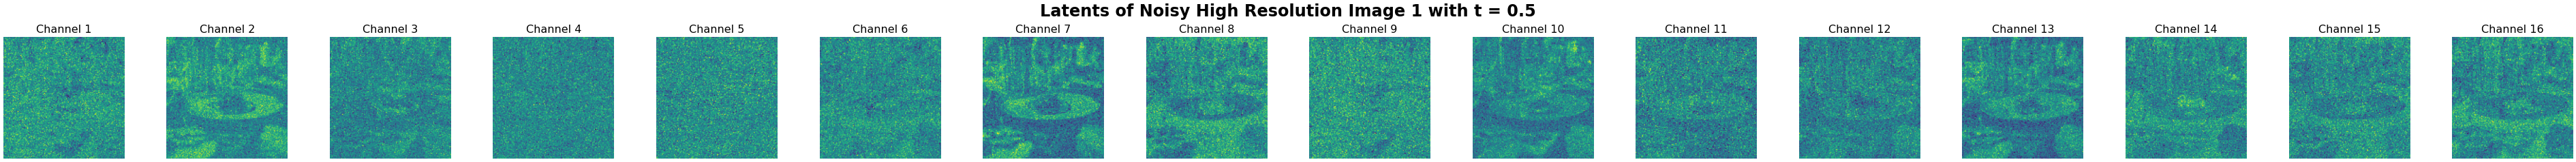

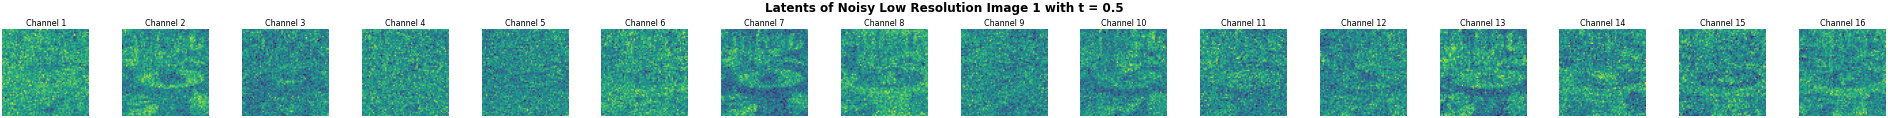

In [88]:
# Blending factor (between 0 and 1)
t = .5 # t = 0 -> only noise, t = 1 -> no noise

# Generate Standard Gaussian Noise tensor
noise_high = torch.randn_like(z_high)
noise_low = torch.randn_like(z_low)
 
# Blend the tensors
z_high_noisy = t * z_high + (1 - t) * noise_high
z_low_noisy = t * z_low + (1 - t) * noise_low

# Visualize latent channels of the first high res image blended with noise
tsor = z_high_noisy
b, c, h, w = tsor.shape
fig, axes = plt.subplots(1, c, figsize=(c * 5, 5), dpi=48)  # Grid for the channels

    # Plot each channel as a single-channel image
for i in range(c):
    ax = axes[i]
    ax.imshow(tsor[0, i].cpu(), cmap='viridis')
    ax.axis('off')  # Hide axes
    ax.set_title(f"Channel {i + 1}", fontsize=24, pad=10)

plt.suptitle(f"Latents of Noisy High Resolution Image 1 with t = {t}", fontsize=36, fontweight="bold")
plt.subplots_adjust(hspace=0.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Visualize latent channels of the first low res image blended with noise
tsor = z_low_noisy
b, c, h, w = tsor.shape
fig, axes = plt.subplots(1, c, figsize=(c * 5, 5), dpi=24)  # Grid for the channels

if c == 1:
    axes = np.expand_dims(axes, axis=1)

# Plot each channel as a single-channel image
for i in range(c):
    ax = axes[i]
    ax.imshow(tsor[0, i].cpu(), cmap='viridis')
    ax.axis('off')  # Hide axes
    ax.set_title(f"Channel {i + 1}", fontsize=24, pad=10)

plt.suptitle(f"Latents of Noisy Low Resolution Image 1 with t = {t}", fontsize=36, fontweight="bold")
plt.subplots_adjust(hspace=0.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## FFT Preprocessing

The latent representations $z$ are preprocessed for Fast Fourier Transform (FFT), following the methodology outlined in [van der Schaaf & van Hateren 1996](https://www.sciencedirect.com/science/article/pii/0042698996000028?ref=pdf_download&fr=RR-2&rr=92c356e8c8a59e0d). The preprocessing steps ensure that the frequency spectrum accurately reflects the spatial information in the latents, preparing them for power spectrum computation.

1. **DC Component Removal:** The DC component is subtracted to isolate oscillatory components carrying spatial information, as the DC component dominates the spectrum in real-world images.

2. **Kaiser Window Application:** A Kaiser window with $\beta = 2$ is applied to minimize spectral leakage, consistent with the paper's methodology.

The DC component $Z[0]$ is calculated after applying the Kaiser window to ensure the mean remains zero, as the windowing process could otherwise introduce a non-zero mean.

$$Z[0] = \frac{\sum{wz}}{\sum{w}}, \quad \text{where } w \text{ is the window function}.$$

The preprocessed tensor $z_{pp}$ is obtained by subtracting the DC component $Z[0]$ and multiplying with the window function $w$.

$$z_{pp} = w(z - Z[0]).$$

This results in $z_{pp}$ tapering to zero at the image borders with a mean of zero.


In [89]:
def preprocess(tensor: torch.Tensor):
    # Create a Kaiser Window
    window_w = torch.kaiser_window(tensor.shape[-1], periodic=True, beta=2)
    window_h = torch.kaiser_window(tensor.shape[-2], periodic=True, beta=2)
    window = window_h.unsqueeze(1) * window_w.unsqueeze(0)
    window = window.to(device)

    # Remove mean of windowed image to remove DC component
    tensor_dc_free = tensor - torch.sum(window * tensor, dim=(2, 3), keepdim=True) / torch.sum(window, dim=(0, 1), keepdim=True).unsqueeze(0).unsqueeze(0)

    # Apply window
    tensor_windowed = tensor_dc_free * window
    return tensor_windowed

z_high_noisy_pp = preprocess(z_high_noisy)
z_low_noisy_pp = preprocess(z_low_noisy)
z_high_pp = preprocess(z_high)
z_low_pp = preprocess(z_low)
noise_high_pp = preprocess(noise_high)
noise_low_pp = preprocess(noise_low)

## Frequency Domain Analysis

The Fourier Transform $Z = \mathcal{F}(z)$ is calculated by running a 2D FFT and shifting the DC component to the center. The accompanying plot visualizes the magnitude and phase of the Fourier Transform for the latent representation of the first high-resolution sample image, blended with Gaussian noise at a specific interpolation factor $t$. The magnitude is displayed on a logarithmic scale to highlight frequency components, clearly showing that the DC component is zero due to prior preprocessing. To preserve the signal’s power, $\mathcal{F}(z)$ is normalized by $\sqrt{N}$, where $N$ is the number of pixels in the latent tensor.

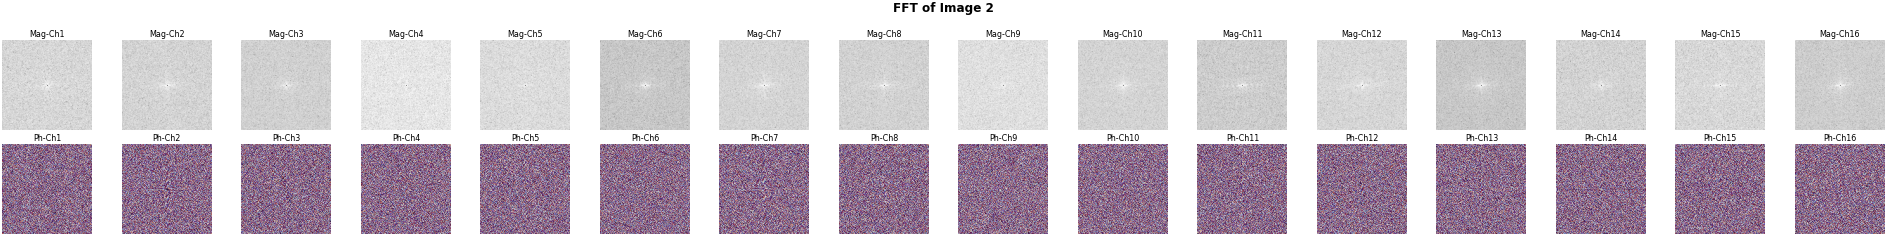

In [90]:
# FFT with norm="ortho" (sqrt(N))
fft_high_noisy = torch.fft.fft2(z_high_noisy_pp, norm="ortho")
fft_high_noisy = torch.fft.fftshift(fft_high_noisy, dim=(2, 3))

fft_low_noisy = torch.fft.fft2(z_low_noisy_pp, norm="ortho")
fft_low_noisy = torch.fft.fftshift(fft_low_noisy, dim=(2, 3))

fft_high = torch.fft.fft2(z_high_pp, norm="ortho")
fft_high = torch.fft.fftshift(fft_high, dim=(2, 3))

fft_low = torch.fft.fft2(z_low_pp, norm="ortho")
fft_low = torch.fft.fftshift(fft_low, dim=(2, 3))

fft_noise_low = torch.fft.fft2(noise_low_pp, norm="ortho")
fft_noise_low = torch.fft.fftshift(fft_noise_low, dim=(2, 3))

fft_noise_high = torch.fft.fft2(noise_high_pp, norm="ortho")
fft_noise_high = torch.fft.fftshift(fft_noise_high, dim=(2, 3))

# Plot FFT of first high res image
mag = torch.abs(fft_high_noisy)
log_mag = torch.log(torch.clamp(mag, min=1e-10))
phase = torch.angle(fft_high_noisy)

# To CPU for plotting
log_mag = log_mag.cpu()
phase = phase.cpu()

b, c, h, w = log_mag.shape  # b is batch size, c is the number of channels, h and w are image dimensions


fig, axes = plt.subplots(2, c, figsize=(5 * c, 10), dpi=24)  # 2 rows (magnitude & phase), channels columns

if c == 1:
    axes = np.expand_dims(axes, axis=1)

# Plot all channels for magnitude (looping over channels, not batch)
for c_idx in range(c):
    ax = axes[0, c_idx]  # First row for magnitude
    ax.imshow(log_mag[b_idx, c_idx].cpu().numpy(), cmap='gray')  # Convert to numpy for imshow
    ax.set_title(f"Mag-Ch{c_idx + 1}", fontsize=24, pad=10)
    ax.axis('off')

# Plot all channels for phase (looping over channels, not batch)
for c_idx in range(c):
    ax = axes[1, c_idx]  # Second row for phase
    ax.imshow(phase[b_idx, c_idx].cpu().numpy(), cmap='twilight')  # Convert to numpy for imshow
    ax.set_title(f"Ph-Ch{c_idx + 1}", fontsize=24, pad=10)
    ax.axis('off')

# Set the title for the current image in the batch
plt.suptitle(f"FFT of Image {b_idx + 1}", fontsize=36, fontweight="bold")
plt.subplots_adjust(hspace=0.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Calculate Radial Averaged Power Spectrum (RAPS)

RAPS represents the power over frequency (distance from the center in the shifted FFT) averaged over all angular directions. For a continuous function $f$, RAPS is defined as:

$$\operatorname{RAPS}(r) = \frac{1}{2\pi} \int_{0}^{2\pi} f(r, \phi) \, d\phi$$

In the discrete case, RAPS is calculated by averaging the power spectrum $||\mathcal{F}(z)||^2$ within radial bins. Linear interpolation is used to distribute the contribution of each pixel across adjacent radial bins, ensuring accurate power allocation. The FFT is normalized by $\sqrt{N}$, where $N$ is the number of pixels in the latent tensor, to preserve total power across the spatial and frequency domains.

### Impact of Noise Blending

The first plot illustrates the effect of noise blending on the RAPS of the first high-resolution sample image’s latent representation. In a log-log plot, the power spectrum exhibits a near-linear decay, consistent with a power-law behavior $P(f) = \beta f^{-\gamma}$, as noted in [van der Schaaf & van Hateren 1996](https://www.sciencedirect.com/science/article/pii/0042698996000028?ref=pdf_download&fr=RR-2&rr=92c356e8c8a59e0d). This decay indicates that natural images have higher power in lower frequencies. Conversely, Gaussian noise exhibits constant power across all frequencies. When blended with noise at interpolation factor $t$, the image’s high-frequency components, where its power is low, are overwhelmed first. This results in a diminished signal-to-noise ratio (SNR) at higher frequencies, causing early loss of fine details. DDPMs reconstruct these details by denoising, effectively performing autocorrelation in the frequency domain, as the model learns to recover frequency-specific information.

### Impact of Resolution

The second plot compares the RAPS of high- and low-resolution latent representations. With FFT normalization by $\sqrt{N}$, the total power of the image’s spectrum is preserved across resolutions. However, the noise spectrum shows higher power per frequency bin in the low-resolution case, despite equal total power integrated across the frequency band. An explanation is given in [Esser et al. 2024](https://arxiv.org/abs/2403.03206). To explore this phenomenon intuitively, two experiments are presented below.

1. **Visual Noise Experiment:** Consider a high-resolution black-and-white image with random pixel intensities viewed from a distance. The fine-grained noise averages to a uniform gray due to the eye’s limited spatial resolution. In contrast, a low-resolution image with larger random pixels retains visible intensity variations at the same distance. This indicates that low-resolution noise has more power in lower frequencies, as large-scale variations are averaged out in the high-resolution case.

2. **Audio Noise Experiment:** Generate Gaussian noise audio at high and low sampling rates. Apply a low-pass filter to the high-sample-rate noise to match the frequency range of the low-sample-rate noise. The filtered high-resolution noise sounds quieter. In contrast, the low-sample-rate noise retains higher power per frequency bin across its narrower bandwidth.

### Implications for Time Step Sampling

These observations align with Robin Rombach’s insight from his lecture ([YouTube link](https://www.youtube.com/live/nrKKLJXBSw0)), which notes that higher-resolution images require more noise (larger $t$ values) to achieve comparable diffusion effects. This is explained by the higher power per frequency bin in low-resolution noise, which dominates the latent representation more effectively. The linear interpolation formula for noise blending:
$$z_t = tz + (1 - t) \epsilon$$

shows that a larger $t$ increases the noise contribution $\epsilon$. For high-resolution images, a higher $t$ is needed to match the effective noise strength of low-resolution images, informing the design of a resolution-weighted time step sampling mentioned in [Esser et al. 2024](https://arxiv.org/abs/2403.03206).

In [91]:
# To CPU for RAPS calculation
fft_high_noisy = fft_high_noisy.cpu()
fft_low_noisy = fft_low_noisy.cpu()
fft_high = fft_high.cpu()
fft_low = fft_low.cpu()
fft_noise_high = fft_noise_high.cpu()
fft_noise_low = fft_noise_low.cpu()

# Calculate RAPS
raps_high_noisy = calc_raps(fft_high_noisy)
raps_high_noisy = torch.mean(raps_high_noisy, dim=1, keepdim=True) # average channels

raps_low_noisy = calc_raps(fft_low_noisy)
raps_low_noisy = torch.mean(raps_low_noisy, dim=1, keepdim=True) # average channels

raps_high = calc_raps(fft_high)
raps_high = torch.mean(raps_high, dim=1, keepdim=True) # average channels

raps_low = calc_raps(fft_low)
raps_low = torch.mean(raps_low, dim=1, keepdim=True) # average channels

raps_noise_low = calc_raps(fft_noise_low)
raps_noise_low = torch.mean(raps_noise_low, dim=1, keepdim=True) # average channels

raps_noise_high = calc_raps(fft_noise_high)
raps_noise_high = torch.mean(raps_noise_high, dim=1, keepdim=True) # average channels

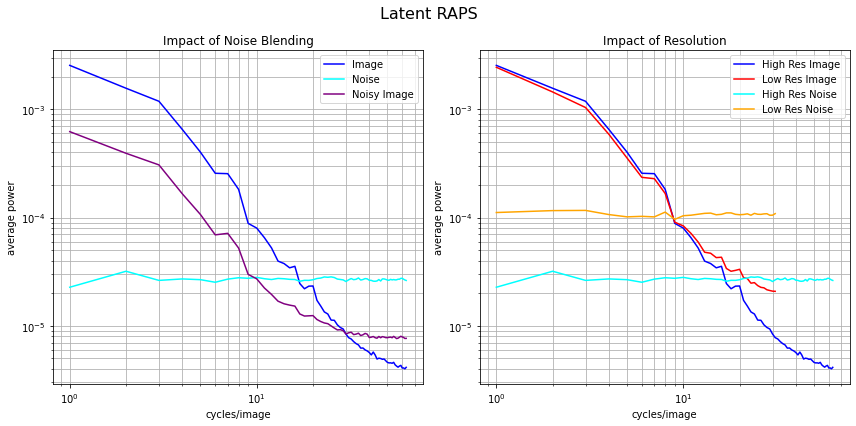

In [92]:
# Plot RAPS without DC bin in log-log scale
fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=72)

ax = axes[0]
ax.plot(np.arange(raps_high.size(-1) - 1) + 1, raps_high[0, 0, 1:], label=f"Image", color="blue") # x axis: (1, 2, .., n)
ax.plot(np.arange(raps_high.size(-1) - 1) + 1, raps_noise_high[0, 0, 1:], label=f"Noise", color="cyan")
ax.plot(np.arange(raps_high.size(-1) - 1) + 1, raps_high_noisy[0, 0, 1:], label=f"Noisy Image", color="purple")
ax.set_title(f"Impact of Noise Blending")
ax.set_xlabel('cycles/image')
ax.set_ylabel('average power')
ax.legend()
ax.grid(True, which='both')
ax.set_xscale('log')
ax.set_yscale('log')

ax = axes[1]
ax.plot(np.arange(raps_high.size(-1) - 1) + 1, raps_high[0, 0, 1:], label=f"High Res Image", color="blue")
ax.plot(np.arange(raps_low.size(-1) - 1) + 1, raps_low[0, 0, 1:], label=f"Low Res Image", color="red")
ax.plot(np.arange(raps_high.size(-1) - 1) + 1, raps_noise_high[0, 0, 1:], label=f"High Res Noise", color="cyan")
ax.plot(np.arange(raps_low.size(-1) - 1) + 1, raps_noise_low[0, 0, 1:], label=f"Low Res Noise", color="orange")
ax.set_title(f"Impact of Resolution")
ax.set_xlabel('cycles/image')
ax.set_ylabel('average power')
ax.legend()
ax.grid(True, which='both')
ax.set_xscale('log')
ax.set_yscale('log')

# Set the title for the current batch item
plt.suptitle(f"Latent RAPS", fontsize=16)
plt.tight_layout()
plt.show()

## Weighting the Sampling Distribution

To identify frequencies in the Radial Average Power Spectrum (RAPS) that carry significant information for weighting a sampling distribution, I identified 2 strategies.

### Strategy 1: Comparing Individual RAPS to the Dataset Average

One approach to identify frequencies that are more prominent in a specific image relative to the dataset average is to compute the mean RAPS across the entire training dataset, denoted as $\overline{P}(f)$. For a given image, the difference between its RAPS, $P_i(f)$, and the average RAPS can be calculated as:

$$\Delta P_i(f) = P_i(f) - \overline{P}(f)$$

This difference highlights frequencies where the image deviates from the dataset's typical spectral profile. However, if the training dataset is diverse, the parameters $\alpha$ and $\beta$ may vary significantly across images. Consequently, $\overline{P}(f)$ may represent a composite of different power-law behaviors, leading to a smoothed or blended spectrum. This could obscure localized frequency spikes and emphasize global differences in the spectral fall-off rather than isolating specific frequency contributions. Strategy 1 is therefore not applied here.

### Strategy 2: Leveraging Power-Law Fit for Relative Differences

An alternative strategy exploits the power-law behavior by fitting the parameters $\alpha$ and $\beta$ to the RAPS of an individual image, yielding a smooth fitted spectrum. To accommodate for non-linearity in log-log-space and to obtain a better fit, a polynomial fit in log-log space is chosen:

$$P_{\text{fit}}(f) = 10^c \cdot f^{b + a \log_{10}(f)}$$

The difference between the actual RAPS, $P_i(f)$, and the fitted spectrum can then be computed. However, since the difference $\Delta P_i(f) = P_i(f) - P_{\text{fit}}(f)$ is typically much larger at low frequencies due to the power-law decay, it may disproportionately emphasize low-frequency deviations. To address this, the ratio is more appropriate:

$$R(f) = \frac{P_i(f)}{P_{\text{fit}}(f)}$$

This ratio provides a measure of how the image's spectrum deviates from its own fitted model. To use $R$ as a weighting factor for the sampling distribution of a variable $t$, the distribution $p(t)$ can be modulated as follows:

$$p_{\text{weighted}}(t) = p(t) \cdot R(t) \quad \text{with} \quad f \to t: \frac{f - f_{\min}}{f_{\max} - f_{\min}}$$

The resulting distribution is then normalized to ensure it integrates to 1:

$$p_{\text{weighted}}(t) \leftarrow \frac{p_{\text{weighted}}(t)}{\int p_{\text{weighted}}(t) , dt}$$

This approach aims to highlight frequencies where the image’s spectrum exceeds its polynomial fit, potentially identifying information-carrying frequencies. However, testing shows that $\Delta_{\text{rel}}(f)$ weightings are often similar across different images and noisy, lacking specificity for distinctive spectral features. Since the analysis here is conducted in latent space with RAPS averaged across channels, the transformation from image to latent space aswell as averaging the channels likely smoothed out spatial details, reducing the ability to detect unique frequency signatures. Analyzing RAPS in the original image space may preserve these details and yield more specific results. Future work could explore computing RAPS on input images, using localized frequency analysis (e.g., wavelets), or incorporating phase information. 

In the following figure, the left plot illustrates the RAPS for the high-resolution latent representation of input images on a log-log scale. The middle plot shows the RAPS for the first image along with its polynomial fit. The right plot depicts the relative ratio $R(f)$ for the first image.

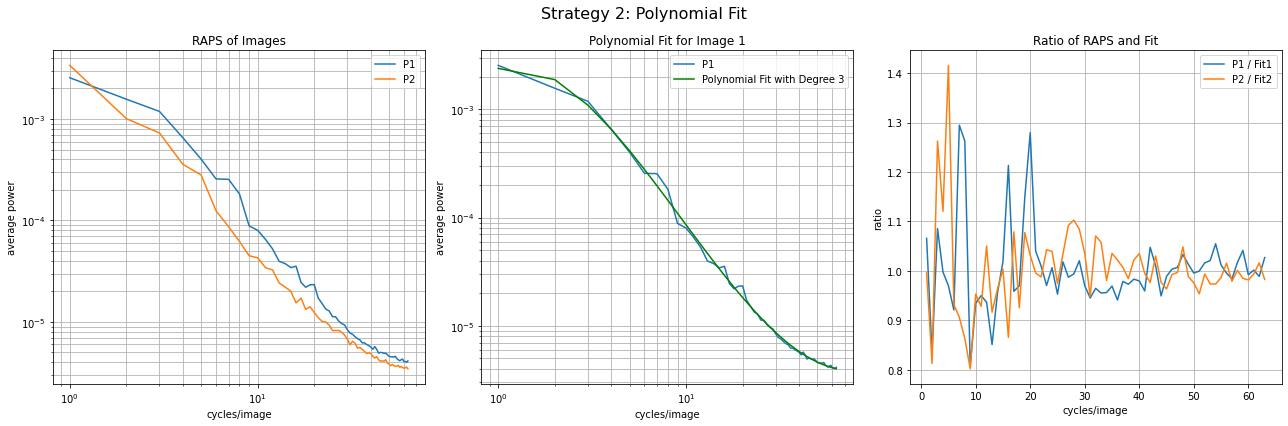

In [93]:
batch, channel, values = raps_high.shape
fits = []
ratios = []
for b in range(batch):
    coeff, fit = fit_loglog_polynomial(np.arange(raps_high.size(-1) - 1) + 1, raps_high[b, 0, 1:].numpy(), degree=3)
    fits.append(fit)
    ratio = raps_high[b, 0, 1:].numpy() / fit
    ratios.append(ratio)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=72)

ax = axes[0]
for b in range(batch):
    ax.plot(np.arange(raps_high.size(-1) - 1) + 1, raps_high[b, 0, 1:], label=f"P{b + 1}")
ax.set_title(f"RAPS of Images")
ax.set_xlabel('cycles/image')
ax.set_ylabel('average power')
ax.legend()
ax.grid(True, which='both')
ax.set_xscale('log')
ax.set_yscale('log')

ax = axes[1]
ax.plot(np.arange(raps_high.size(-1) - 1) + 1, raps_high[0, 0, 1:], label=f"P1")
ax.plot(np.arange(raps_high.size(-1) - 1) + 1, fits[0], label=f"Polynomial Fit with Degree 3", color="green")
ax.set_title(f"Polynomial Fit for Image 1")
ax.set_xlabel('cycles/image')
ax.set_ylabel('average power')
ax.legend()
ax.grid(True, which='both')
ax.set_xscale('log')
ax.set_yscale('log')

ax = axes[2]
for idx in range(len(ratios)):
    ax.plot(np.arange(raps_high.size(-1) - 1) + 1, ratios[idx], label=f"P{idx +1} / Fit{idx +1}")
ax.set_title(f"Ratio of RAPS and Fit")
ax.set_xlabel('cycles/image')
ax.set_ylabel('ratio')
ax.legend()
ax.grid(True)

plt.suptitle(f"Strategy 2: Polynomial Fit", fontsize=16)
plt.tight_layout()
plt.show()

## Adjusting the Sampling Distribution for Resolution Compensation

Following further analysis, I developed a method to adjust the sampling distribution of $t$ to account for resolution changes in the latent space. Subsequently, I reviewed [Esser et al. 2024](https://arxiv.org/abs/2403.03206), which arrived at a comparable approach before, validating the findings.

### Signal-to-Noise Ratio (SNR) Analysis

The signal-to-noise ratio, ${SNR}(f)$, of the latents $z_t$ is illustrated below for the first image at both high and low resolutions. The plot reveals that, for a fixed $t$, the SNR varies with resolution. Specifically, higher resolutions retain more information at the same $t$, reducing the noise level compared to lower resolutions. This discrepancy affects model performance, as higher-resolution training spends less time capturing critical low-frequency information, as highlighted by Robin in the referenced video. Adjusting the sampling distribution of $t$ can mitigate this issue by aligning the SNR across resolutions, ensuring consistent training.

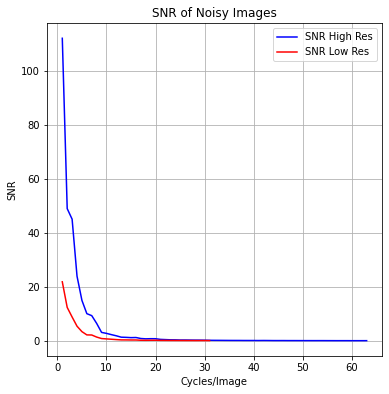

In [94]:
snr_high = (t ** 2 * raps_high / ((1 - t) ** 2 * raps_noise_high))
snr_low = (t ** 2 * raps_low / ((1 - t) ** 2 * raps_noise_low))

# Create the plot
fig, ax = plt.subplots(figsize=(6, 6), dpi=72)
ax.plot(np.arange(snr_high.size(-1) - 1) + 1, snr_high[0, 0, 1:], color='blue', label='SNR High Res')  # Plot with blue line and label
ax.plot(np.arange(snr_low.size(-1) - 1) + 1, snr_low[0, 0, 1:], color='red', label='SNR Low Res')  # Plot with blue line and label

plt.xlabel('Cycles/Image')
plt.ylabel('SNR')
plt.title('SNR of Noisy Images')
plt.legend()
plt.grid(True)
plt.show()

### Deriving SNR Distribution

As previously established, the power spectrum of Gaussian noise scales with resolution $N = hw$ and is given by $P_n(h, w) = \frac{P_0}{hw}$, where $h$ and $w$ represent the height and width of the noise, and $P_0$ is a constant. The power spectrum of real images follows $P_i(f) \approx \beta f^{-\gamma}$. Consequently, the signal-to-noise ratio (SNR) for a given resolution $hw$ and frequency $f$ is:

$$SNR(t) = \frac{t^2}{(1-t)^2} \frac{P_i(f)}{P_n(h, w)} \approx \frac{t^2}{(1-t)^2} \frac{\beta}{P_0} \frac{hw}{f^\gamma}$$

When $t$ follows a logit-normal distribution, it is defined as:

$$t = \frac{e^\theta}{1 + e^\theta}, \text{ where } \theta \sim \mathcal{N}(\mu, \sigma^2)$$

Transforming $y = \frac{t^2}{(1-t)^2}$ to $t = \frac{\sqrt{y}}{1 + \sqrt{y}}$ and substituting into the SNR expression yields:

$$SNR = k e^{2\theta}, \text{ where } k = \frac{\beta hw}{P_0 f^\gamma} \text{ and } 2\theta \sim \mathcal{N}(2\mu, 4\sigma^2)$$

Thus, the SNR is lognormally distributed:

$$SNR \sim k \operatorname{Lognormal}(2\mu, 4\sigma^2) = \operatorname{Lognormal}(2\mu + \ln(k), 4\sigma^2)$$

### Calculating the Distribution Offset

The expected value of a lognormal random variable $X \sim \operatorname{Lognormal}(m, v)$ is:

$$\operatorname{E}[X] = e^{m + \frac{v}{2}}$$

Applying this to the SNR, we get:

$$\operatorname{E}[SNR] = e^{2\mu + \ln(k) + 2\sigma^2} = e^{2\mu + 2\sigma^2} \cdot \frac{\beta hw}{P_0 f^\gamma}$$

To align the expected SNR with a reference $\operatorname{E}[SNR_0]$ at resolution $h_0w_0$, we equate:

$$\operatorname{E}[SNR_0] = e^{2\mu_0 + 2\sigma^2} \cdot \frac{\beta h_0w_0}{P_0 f^\gamma} = e^{2\mu + 2\sigma^2} \cdot \frac{\beta hw}{P_0 f^\gamma} = \operatorname{E}[SNR]$$

Solving for $\mu$, we obtain:

$$\mu = \mu_0 + \frac{1}{2} \ln \left( \frac{h_0w_0}{hw} \right)$$

### Visualizing the Adjusted Distribution

This formula provides a method to adjust the mean $\mu$ of the normal distribution $\theta$ used to sample the logit-normal distributed $t = \frac{e^\theta}{1 + e^\theta}$, compensating for resolution differences. The following code visualizes the noisy latents and SNR for the first image at high and low resolutions, given a standard normal sample. The visualization includes three plots:

1. High-resolution image with original $t$: Displays the latent with less noise due to higher resolution.

2. High-resolution image with adjusted $t$: Shows the latent after applying the adjusted $t$, closely matching the noise level of the low-resolution image.

3. Low-resolution image with original $t$: Exhibits higher noise levels, highlighting the resolution-dependent effect.

Additionally, the SNR for the low-resolution image and the adjusted-$t$ high-resolution image are plotted. These plots demonstrate a striking similarity, confirming that the adjustment effectively normalizes noise characteristics across resolutions.

Interpolation Factor t = 0.5
Shifted Interpolation Factor t_shifted = 0.3333333333333333


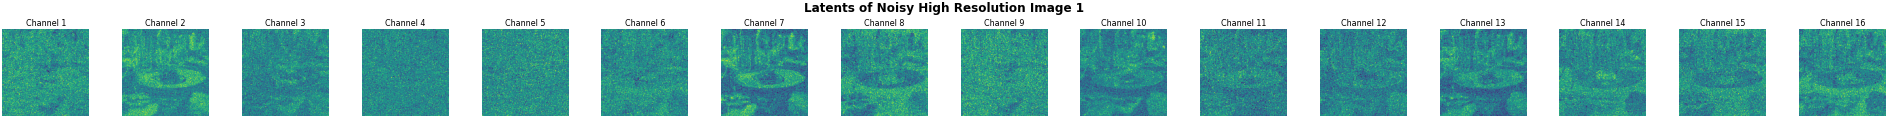

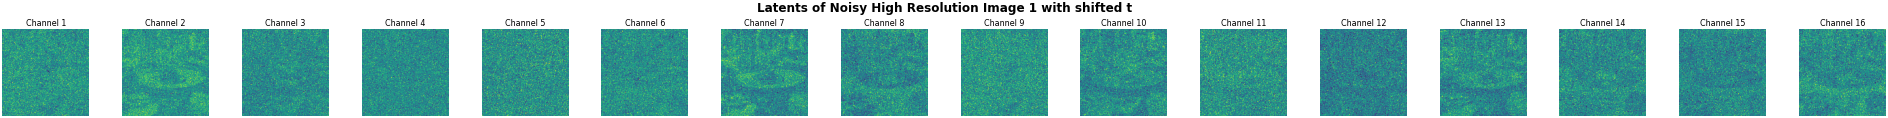

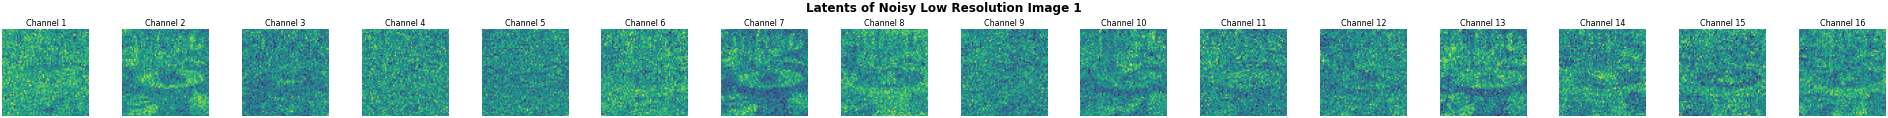

In [95]:
std_norm_sample = 0
std_norm_sample_shifted = std_norm_sample + 0.5 * np.log(low_res ** 2 / high_res ** 2)

t2 = 1 / (1 + np.exp(-std_norm_sample))
t2_shifted = 1 / (1 + np.exp(-std_norm_sample_shifted))

print(f"Interpolation Factor t = {t2}")
print(f"Shifted Interpolation Factor t_shifted = {t2_shifted}")

z_high_noisy_2 = t2 * z_high + (1 - t2) * noise_high
z_high_noisy_2_shifted = t2_shifted * z_high + (1 - t2_shifted) * noise_high
z_low_noisy_2 = t2 * z_low + (1 - t2) * noise_low

# Visualize latent channels of the first low res image blended with noise
tsor = z_high_noisy_2
b, c, h, w = tsor.shape
fig, axes = plt.subplots(1, c, figsize=(c * 5, 5), dpi=24)  # Grid for the channels

if c == 1:
    axes = np.expand_dims(axes, axis=1)

# Plot each channel as a single-channel image
for i in range(c):
    ax = axes[i]
    ax.imshow(tsor[0, i].cpu(), cmap='viridis')
    ax.axis('off')  # Hide axes
    ax.set_title(f"Channel {i + 1}", fontsize=24, pad=10)

plt.suptitle(f"Latents of Noisy High Resolution Image 1", fontsize=36, fontweight="bold")
plt.subplots_adjust(hspace=0.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Visualize latent channels of the first low res image blended with noise
tsor = z_high_noisy_2_shifted
b, c, h, w = tsor.shape
fig, axes = plt.subplots(1, c, figsize=(c * 5, 5), dpi=24)  # Grid for the channels

if c == 1:
    axes = np.expand_dims(axes, axis=1)

# Plot each channel as a single-channel image
for i in range(c):
    ax = axes[i]
    ax.imshow(tsor[0, i].cpu(), cmap='viridis')
    ax.axis('off')  # Hide axes
    ax.set_title(f"Channel {i + 1}", fontsize=24, pad=10)

plt.suptitle(f"Latents of Noisy High Resolution Image 1 with shifted t", fontsize=36, fontweight="bold")
plt.subplots_adjust(hspace=0.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Visualize latent channels of the first low res image blended with noise
tsor = z_low_noisy_2
b, c, h, w = tsor.shape
fig, axes = plt.subplots(1, c, figsize=(c * 5, 5), dpi=24)  # Grid for the channels

if c == 1:
    axes = np.expand_dims(axes, axis=1)

# Plot each channel as a single-channel image
for i in range(c):
    ax = axes[i]
    ax.imshow(tsor[0, i].cpu(), cmap='viridis')
    ax.axis('off')  # Hide axes
    ax.set_title(f"Channel {i + 1}", fontsize=24, pad=10)

plt.suptitle(f"Latents of Noisy Low Resolution Image 1", fontsize=36, fontweight="bold")
plt.subplots_adjust(hspace=0.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

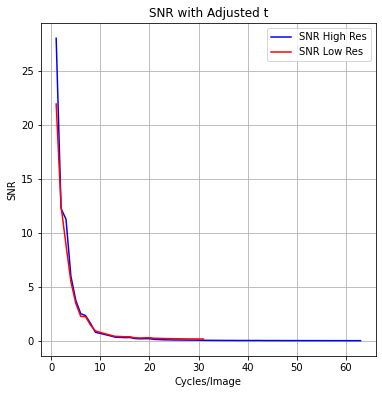

In [96]:
snr_high = (t2_shifted ** 2 * raps_high / ((1 - t2_shifted) ** 2 * raps_noise_high))
snr_low = (t2 ** 2 * raps_low / ((1 - t2) ** 2 * raps_noise_low))

# Create the plot
fig, ax = plt.subplots(figsize=(6, 6), dpi=72)
ax.plot(np.arange(snr_high.size(-1) - 1) + 1, snr_high[0, 0, 1:], color='blue', label='SNR High Res')  # Plot with blue line and label
ax.plot(np.arange(snr_low.size(-1) - 1) + 1, snr_low[0, 0, 1:], color='red', label='SNR Low Res')  # Plot with blue line and label

plt.xlabel('Cycles/Image')
plt.ylabel('SNR')
plt.title('SNR with Adjusted t')
plt.legend()
plt.grid(True)
plt.show()

## Comparison with Literature

In [Esser et al. 2024](https://arxiv.org/abs/2403.03206), the authors propose adjusting the time schedule for sampling images using a shift factor $\alpha = \sqrt{\frac{m}{n}}$, where $m, n = H \cdot W$ represent the pixel counts of images at different resolutions. The SNR-based adjustment derived here yields a shift factor of 2 when scaling from a resolution of $512^2$ to $1024^2$ pixels, as it accounts for the resolution-dependent noise scaling. However, a human preference study in the paper indicates a preference for a shift factor greater than 2, suggesting that additional factors influence perceptual quality at higher resolutions.

Possible explanations for this discrepancy include:

1. **Impact of Dimensionality on Diffusion Trajectories:** Higher resolutions increase the dimensionality of the latent space, leading to a larger average Euclidean distance between a random noise sample and the target image. This extends the reverse diffusion path, amplifying the impact of early integration errors or path inaccuracies. A well-structured vector field, or a straighter trajectory in rectified flow models, particularly at early stages (low $t$), could enhance sample quality. Finer sampling of the early diffusion path, achieved by shifting the time schedule, may be especially critical at higher resolutions to mitigate these errors.

2. **Volume Scaling in High-Dimensional Spaces:** In a hypersphere of volume $V$ with radius $r$ in high-dimensional spaces, the volume increment $\frac{dV}{dr}$ grows significantly with dimensionality. For a $d$-dimensional hypersphere, the volume is $V \propto r^d$, so $\frac{dV}{dr} \propto d r^{d-1}$. At higher resolutions (larger $d$), the volume of regions far from the data manifold (corresponding to high $t$, or noisier states) increases rapidly. This necessitates more training in these regions to ensure a robust vector field, requiring a shift in the distribution to emphasize sampling at higher noise levels.

3. **Nonlinearities and Training Dynamics**: The discrepancy may also stem from nonlinearities in the model architecture or training dynamics. For instance, the model's loss function, regularization, or optimization process might interact differently with resolution changes, leading to non-linear scaling effects that the SNR-based adjustment does not fully capture. These factors could prioritize certain $t$ ranges or amplify the importance of specific noise levels, necessitating a larger shift factor to align with human-perceived quality.

These hypotheses suggest that while the SNR-based adjustment is theoretically sound, perceptual, geometric, and model-specific factors in high-dimensional spaces may require a larger shift factor to optimize human-preferred outcomes, aligning with Esser et al.'s findings.